In [1757]:
import numpy as np
import pandas as pd
from dbfread import DBF

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mutual_info_score, confusion_matrix, auc, roc_auc_score, roc_curve, RocCurveDisplay, precision_score, recall_score, accuracy_score

import xgboost as xgb

## Data Import

In [1758]:
def read_dbf(filename: str) -> pd.DataFrame:
  return pd.DataFrame(DBF(filename))

In [1759]:
# MEMBERS
df_members = read_dbf('./data/members.DBF')

# EXPEDITIONS
df_exped = read_dbf('./data/exped.DBF')

# PEAKS
df_peaks = read_dbf('./data/peaks.DBF')

## Data Cleaning

In [1760]:
def standardize_colnames(df: pd.DataFrame) -> pd.DataFrame:
  df.columns = df.columns.str.lower()

### Members

In [1761]:
df_members.head()

,EXPID,MEMBID,PEAKID,MYEAR,MSEASON,FNAME,LNAME,SEX,AGE,BIRTHDATE,YOB,CALCAGE,CITIZEN,STATUS,RESIDENCE,OCCUPATION,LEADER,DEPUTY,BCONLY,NOTTOBC,SUPPORT,DISABLED,HIRED,SHERPA,TIBETAN,MSUCCESS,MCLAIMED,MDISPUTED,MSOLO,MTRAVERSE,MSKI,MPARAPENTE,MSPEED,MHIGHPT,MPERHIGHPT,MSMTDATE1,MSMTDATE2,MSMTDATE3,MSMTTIME1,MSMTTIME2,MSMTTIME3,MROUTE1,MROUTE2,MROUTE3,MASCENT1,MASCENT2,MASCENT3,MO2USED,MO2NONE,MO2CLIMB,MO2DESCENT,MO2SLEEP,MO2MEDICAL,MO2NOTE,DEATH,DEATHDATE,DEATHTIME,DEATHTYPE,DEATHHGTM,DEATHCLASS,AMS,WEATHER,INJURY,INJURYDATE,INJURYTIME,INJURYTYPE,INJURYHGTM,DEATHNOTE,MEMBERMEMO,NECROLOGY,MSMTBID,MSMTTERM,HCN,MCHKSUM,MSMTNOTE1,MSMTNOTE2,MSMTNOTE3,DEATHRTE
0,AMAD78301,01,AMAD,1978,3,Jean Robert,Clemenson,M,0,None,1938,40,France,Leader,"Argentiere, Haute-Savoie, France",Alpine guide,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,None,False,0,None,None,None,,,,0,0,0,0,0,0,False,True,False,False,False,False,,False,None,,0,0,0,False,False,False,None,,0,0,,None,None,1,4,0,2426937,NaN,NaN,NaN,NaN
1,AMAD78301,02,AMAD,1978,3,Bernard,Dufour,M,0,None,1936,41,France,Deputy Leader,"Les Houches, Haute-Savoie, France",Alpine guide,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,None,True,6000,1978-10-21,None,None,,,,1,0,0,0,0,0,False,True,False,False,False,False,,False,None,,0,0,0,False,False,False,None,,0,0,,None,None,1,4,0,2426501,NaN,NaN,NaN,NaN
2,AMAD78301,03,AMAD,1978,3,Philippe,Gerard,M,0,None,1950,27,France,Climber,"Troyes, Val-de-Marne, France",Professional photographer,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,None,False,0,None,None,None,,,,0,0,0,0,0,0,False,True,False,False,False,False,,False,None,,0,0,0,False,False,False,None,,0,0,,None,None,1,4,0,2431569,NaN,NaN,NaN,NaN
3,AMAD78301,04,AMAD,1978,3,Eric,Lasserre,M,0,None,1937,40,France,Exp Doctor,"Chamonix, Haute-Savoie, France",Physician,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,None,True,6000,1978-10-21,None,None,,,,1,0,0,0,0,0,False,True,False,False,False,False,,False,None,,0,0,0,False,False,False,None,,0,0,,None,None,1,4,0,2426809,NaN,NaN,NaN,NaN
4,AMAD78301,05,AMAD,1978,3,Guy,Peters,M,0,None,1944,34,France,Climber,"Les Houches, Haute-Savoie, France",Alpine guide,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,None,False,0,None,None,None,,,,0,0,0,0,0,0,False,True,False,False,False,False,,False,None,,0,0,0,False,False,False,None,,0,0,,None,None,1,4,0,2429215,NaN,NaN,NaN,NaN


In [1762]:
standardize_colnames(df_members)

In [1763]:
col_list = [
  # KEY COLUMNS
  'expid',
  'membid',
  'peakid',
  # EXPEDITION TIME
  'myear',
  'mseason',
  # MEMBER PERSONAL DETAILS
  'fname',
  'lname',
  'sex',
  'yob',
  'calcage',
  'status',
  # MEMBER ROLE
  'leader',
  'deputy',
  'bconly',
  'nottobc',
  'support',
  'disabled',
  'hired',
  'sherpa',
  'tibetan',
  # EXPEDITION OUTCOME
  'msuccess',
  # EXPEDITION TYPE
  'msolo',
  'mtraverse',
  'mski',
  'mparapente',
  'mspeed',
  # SUMMIT BID DETAILS
  # 'mperhighpt',
  'msmtdate1',
  'msmttime1',
  # SUMMIT BID
  'msmtbid',
  'msmtterm'
]

In [1764]:
df_members = df_members[col_list]
df_members.rename(columns={'calcage': 'age'}, inplace=True)

In [1765]:
df_members.shape

(87156, 30)

In [1766]:
# 11 – O2 system failure
# 14 – Assisting, guiding, supporting or accompanying others
# 15 – Route/camp preparation or rope fixing
# 17 – Did not climb or intent to summit
df_members = df_members.loc[~df_members.msmtterm.isin([11, 14, 15, 17]), :]
df_members.drop('msmtterm', axis=1, inplace=True)

In [1767]:
# exclude members with support roles
df_members = df_members.loc[
  (df_members.bconly == False) &
  (df_members.nottobc == False) &
  (df_members.support == False) &
  (df_members.hired == False) &
  (df_members.sherpa == False) &
  (df_members.tibetan == False)
]

df_members.drop(['bconly', 'nottobc', 'support', 'disabled', 'hired', 'sherpa', 'tibetan'], axis=1, inplace=True)

In [1768]:
# exclude expeditions involving non-climbing activities
df_members = df_members.loc[
  (df_members.mtraverse == False) &
  (df_members.mski == False) &
  (df_members.mparapente == False) &
  (df_members.mspeed == False),
  :
]

df_members.drop(['mtraverse', 'mski', 'mparapente', 'mspeed'], axis=1, inplace=True)

In [1769]:
# keep only members with leader/climber status
df_members.status = df_members.status.str.lower()

df_members = df_members.loc[
  (df_members.status.str.contains('climb')) |
  (df_members.status.str.contains('lead')),
  :
]

df_members = df_members.loc[
  (~df_members.status.str.contains('non-climber')) &
  (~df_members.status.str.contains('ski')) &
  (~df_members.status.str.contains('paraglider')) &
  (~df_members.status.str.contains('camera')) &
  (~df_members.status.str.contains('photo')) &
  (~df_members.status.str.contains('film')) &
  (~df_members.status.str.contains('reporter')) &
  (~df_members.status.str.contains('journalist')) &
  (~df_members.status.str.contains('coach')) &
  (~df_members.status.str.contains('advisor')) &
  (~df_members.status.str.contains('instructor')) &
  (~df_members.status.str.contains('support')) &
  (~df_members.status.str.contains('guide')) &
  (~df_members.status.str.contains('torch')) &
  (~df_members.status.str.contains('only'))
]

df_members.drop(['status'], axis=1, inplace=True)

In [1770]:
df_members = df_members.loc[df_members.sex.isin(['M', 'F']), :]

In [1771]:
df_members.head()

,expid,membid,peakid,myear,mseason,fname,lname,sex,yob,age,leader,deputy,msuccess,msolo,msmtdate1,msmttime1,msmtbid
192,AMAD85101,02,AMAD,1985,1,Carlo,Alde,M,1964,20,False,False,True,False,1985-04-23,,5
209,AMAD85301,07,AMAD,1985,3,Hermann,Comploj,M,1957,28,False,False,True,False,1985-11-03,,5
213,AMAD85303,02,AMAD,1985,3,Maximilian-Horst,Fankhauser,M,1944,41,False,False,True,False,1985-10-31,,5
458,AMAD90301,06,AMAD,1990,3,Martha,Deflorin,F,1951,39,False,False,False,False,None,,1
489,AMAD90307,02,AMAD,1990,3,David,Auble,M,1959,31,False,False,False,False,1990-11-12,,4


In [1772]:
df_members.shape

(24255, 17)

In [1773]:
df_members.columns

Index(['expid', 'membid', 'peakid', 'myear', 'mseason', 'fname', 'lname',
       'sex', 'yob', 'age', 'leader', 'deputy', 'msuccess', 'msolo',
       'msmtdate1', 'msmttime1', 'msmtbid'],
      dtype='object')

#### Data Checks

In [1774]:
# a single entry per expedition/member combination
df_members.groupby(['expid', 'membid']).size().max() == 1

True

In [1775]:
# member success does not match summit bid entry
df_members.loc[df_members.msuccess != (df_members.msmtbid == 5)]
df_members.drop('msmtbid', axis=1, inplace=True)

#### Feature Engineering

In [1776]:
# compute a proxy for climber experience: the cumulative count of expeditions the climber has been on
df_members = df_members.sort_values(['myear', 'mseason', 'msmtdate1', 'msmttime1']).reset_index(drop=True)
df_members['member_experience'] = df_members.groupby(['fname', 'lname', 'sex', 'yob'])['expid'].transform('cumcount')
df_members.drop(['fname', 'lname', 'yob', 'msmtdate1', 'msmttime1'], inplace=True, axis=1)

In [1777]:
# keep only expeditions since 2000
df_members.myear = df_members.myear.astype(int)
df_members = df_members.loc[df_members.myear >= 2000]

### Peaks

In [1778]:
standardize_colnames(df_peaks)
df_peaks.head()

,peakid,pkname,pkname2,location,heightm,heightf,himal,region,open,unlisted,trekking,trekyear,restrict,phost,pstatus,peakmemo,pyear,pseason,pexpid,psmtdate,pcountry,psummiters,psmtnote,refermemo,photomemo
0,AMAD,Ama Dablam,Amai Dablang,Khumbu Himal,6814,22356,12,2,True,False,False,,,1,2,"Other map altitudes:\r\n 6814m - HMG-MT, HMG...",1961,1,AMAD61101,Mar 13,"New Zealand, USA, UK","Mike Gill, Wally Romanes, Barry Bishop, Michae...",,None,W Face (High 126:5 May 1993)\r\nSE Face (High ...
1,AMPG,Amphu Gyabjen,Amphu Gyabien,Khumbu Himal (N of Ama Dablam),5630,18471,12,2,True,False,False,,Opened in 2002,1,2,"Other map altitudes:\r\n 5630m - HMG-Finn, N...",1953,1,AMPG53101,Apr 11,UK,"John Hunt, Tom Bourdillon",,None,None
2,ANN1,Annapurna I,,Annapurna Himal,8091,26545,1,5,True,False,False,,,1,2,"Other map altitudes:\r\n 8091m - HMG-MT, HMG...",1950,1,ANN150101,Jun 03,France,"Maurice Herzog, Louis Lachenal",,Dyhrenfurth history 1950-1977 (MM 58:44-47 Nov...,S Face (High 122:3 Jan 1993) (Beghin accident)...
3,ANN2,Annapurna II,,Annapurna Himal,7937,26040,1,5,True,False,False,,,1,2,"Other map altitudes:\r\n 7937m - HMG-MT, HMG...",1960,1,ANN260101,May 17,"UK, Nepal","Richard Grant, Chris Bonington, Ang Nyima Sherpa",,Dyhrenfurth history 1960-1976 (MM 51:36-37 Sep...,N Face (MM 51:36 Sep 1976)
4,ANN3,Annapurna III,,Annapurna Himal,7555,24787,1,5,True,False,False,,,1,2,"Other map altitudes:\r\n 7555m - HMG-MT, HMG...",1961,1,ANN361101,May 06,India,"Mohan S. Kohli, Sonam Gyatso, Sonam Girmi",,None,S Side (MM 125:11 Jan 1989)\r\nSW Face (MM 71:...


In [1779]:
columns = df_peaks.columns
print(columns)

Index(['peakid', 'pkname', 'pkname2', 'location', 'heightm', 'heightf',
       'himal', 'region', 'open', 'unlisted', 'trekking', 'trekyear',
       'restrict', 'phost', 'pstatus', 'peakmemo', 'pyear', 'pseason',
       'pexpid', 'psmtdate', 'pcountry', 'psummiters', 'psmtnote', 'refermemo',
       'photomemo'],
      dtype='object')


In [1780]:
col_list = [
  'peakid',
  'heightm',
  'himal',
  'region',
  'open', # Peak open
  'unlisted', # Peak unlisted
  'trekking', # Trekking peak
  'pstatus', # Peak climbing status
]

In [1781]:
df_peaks = df_peaks[col_list]

In [1782]:
df_peaks = df_peaks.loc[
  (df_peaks.trekking == False) &
  (df_peaks.open == True) &
  (df_peaks.unlisted == False)]
df_peaks.drop(['trekking', 'open', 'unlisted'], axis=1, inplace=True)

In [1783]:
df_peaks.himal = df_peaks.himal.astype(str)
df_peaks.region = df_peaks.region.astype(str)

df_peaks.climbed = df_peaks.pstatus == 2
df_peaks.drop('pstatus', axis=1, inplace=True)

/var/folders/qc/25kj3qbn6v7_d1y6n192nrzm0000gn/T/ipykernel_24545/3861500919.py:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_peaks.climbed = df_peaks.pstatus == 2


In [1784]:
df_peaks.shape

(384, 4)

In [1785]:
df_peaks.head()

,peakid,heightm,himal,region
0,AMAD,6814,12,2
1,AMPG,5630,12,2
2,ANN1,8091,1,5
3,ANN2,7937,1,5
4,ANN3,7555,1,5


### Expeditions

In [1786]:
standardize_colnames(df_exped)
df_exped.head()

,expid,peakid,year,season,host,route1,route2,route3,route4,nation,leaders,sponsor,success1,success2,success3,success4,ascent1,ascent2,ascent3,ascent4,claimed,disputed,countries,approach,bcdate,smtdate,smttime,smtdays,totdays,termdate,termreason,termnote,highpoint,traverse,ski,parapente,camps,rope,totmembers,smtmembers,mdeaths,tothired,smthired,hdeaths,nohired,o2used,o2none,o2climb,o2descent,o2sleep,o2medical,o2taken,o2unkwn,othersmts,campsites,routememo,accidents,achievment,agency,comrte,stdrte,primrte,primmem,primref,primid,chksum
0,ANN260101,ANN2,1960,1,1,NW Ridge-W Ridge,,,,UK,J. O. M. Roberts,,True,False,False,False,1st,,,,False,False,"India, Nepal",Marshyangdi->Hongde->Sabje Khola,1960-03-15,1960-05-17,1530,63,0,None,1,,7937,False,False,False,6,0,10,2,0,9,1,0,False,True,False,True,False,True,False,False,False,Climbed Annapurna IV (ANN4-601-01),"BC(15/03,3350m),ABC(4575m),C1(5365m),C2(5800m)...",None,,,,None,None,False,False,None,,2442047
1,ANN269301,ANN2,1969,3,1,NW Ridge-W Ridge,,,,Yugoslavia,Ales Kunaver,Mountaineering Club of Slovenia,True,False,False,False,2nd,,,,False,False,,Marshyangdi->Hongde->Sabje Khola,1969-09-25,1969-10-22,1800,27,31,1969-10-26,1,,7937,False,False,False,6,0,10,2,0,0,0,0,False,False,True,False,False,False,False,False,False,Climbed Annapurna IV (ANN4-693-02),"LowBC(25/09,3950m),BC(27/09,4650m),C1(27/09,53...","Summited after sunset, returned to C6 at 2:30 ...",Draslar frostbitten hands and feet,,,None,None,False,False,None,,2445501
2,ANN273101,ANN2,1973,1,1,W Ridge-N Face,,,,Japan,Yukio Shimamura,Sangaku Doshikai Annapurna II Expedition 1973,True,False,False,False,3rd,,,,False,False,,Marshyangdi->Pisang->Salatang Khola,1973-03-16,1973-05-06,2030,51,0,None,1,,7937,False,False,False,5,0,6,1,0,8,0,0,False,False,True,False,False,False,False,False,False,,"BC(16/03,3300m),C1(21/03,4200m),C2(10/04,5000m...","Summit team of 3 left from C6, 2 returned from...",,,,None,None,False,False,None,,2446797
3,ANN278301,ANN2,1978,3,1,N Face-W Ridge,,,,UK,Richard J. Isherwood,British Annapurna II Expedition,False,False,False,False,,,,,False,False,,Marshyangdi->Pisang->Salatang Khola,1978-09-08,1978-10-02,,24,27,1978-10-05,4,Abandoned at 7000m (on A-IV) due to bad weather,7000,False,False,False,0,0,2,0,0,0,0,0,True,False,True,False,False,False,False,False,False,,"BC(08/09,5190m),xxx(02/10,7000m)",Alpine-style ascent. Originally planned N Face...,,,,None,None,False,False,None,,2448822
4,ANN279301,ANN2,1979,3,1,N Face-W Ridge,NW Ridge of A-IV,,,UK,Paul Moores,,False,False,False,False,,,,,False,False,,Pokhara->Marshyangdi->Pisang->Sabje Khola,None,1979-10-18,,0,0,1979-10-20,4,Abandoned at 7160m due to high winds,7160,False,False,False,0,0,3,0,0,0,0,0,True,False,True,False,False,False,False,False,False,,"BC(3500m),ABC,Biv1,Biv2,Biv3,Biv4,Biv5,xxx(18/...",Paul Moores - 23 Oct 79\r\n\r\nAlan's illness ...,,,,None,None,False,False,None,,2449204


In [1787]:
col_list = [
  # ID COLUMNS
  'expid',
  'peakid',
  # EXPEDICTION TIME
  'year',
  'season',
  'host',
  'bcdate',
  'smtdate',
  'smttime',
  'termdate',
  # ASCENT DETAILS
  'termreason',
  # EXPEDITION TYPE
  'traverse',
  'ski',
  'parapente',
  # EQUIPMENT
  'camps',
  'rope',
  # TEAM SIZE
  'totmembers',
  'smtmembers',
  'tothired',
  'smthired',
  'nohired',
  # MISC
  'agency',
  # ROUTE
  'stdrte',
  'comrte'
]

In [1788]:
df_exped = df_exped[col_list]

In [1789]:
# 12 – Did not attempt climb
# 13 – Attempt rumored 
df_exped = df_exped.loc[~df_exped.termreason.isin([12, 13]), :]
df_exped.drop('termreason', axis=1, inplace=True)

In [1790]:
df_exped = df_exped.loc[
  (df_exped.traverse == False) &
  (df_exped.parapente == False) &
  (df_exped.ski == False)
]
df_exped.drop(['traverse', 'parapente', 'ski'], axis=1, inplace=True)

In [1791]:
df_exped.host = df_exped.host.astype(str)

#### Feature Engineering

In [1792]:
# compute agency experience
df_exped.sort_values(['year', 'season', 'bcdate', 'smtdate', 'smttime', 'termdate'], inplace=True)
df_exped['agency_experience'] = df_exped.groupby('agency')['expid'].transform('cumcount')
df_exped.drop(['bcdate', 'smtdate', 'smttime', 'termdate', 'agency'], axis=1, inplace=True)

In [1793]:
df_exped.year = df_exped.year.astype(int)
df_exped = df_exped.loc[df_exped.year >= 2000]

In [1794]:
df_exped.head()

,expid,peakid,year,season,host,camps,rope,totmembers,smtmembers,tothired,smthired,nohired,stdrte,comrte,agency_experience
3589,JANU00101,JANU,2000,1,1,2,0,3,2,0,0,True,None,None,0
3506,BARU00102,BARU,2000,1,1,2,0,5,5,4,4,False,None,None,15
3537,EVER00105,EVER,2000,1,1,4,0,9,3,6,0,False,True,True,5
3607,MANA00101,MANA,2000,1,1,3,400,4,3,0,0,True,True,True,10
3495,AMAD00111,AMAD,2000,1,1,2,0,6,0,0,0,True,False,True,289


In [1795]:
df_exped = df_exped.loc[
  (df_exped.stdrte.notna()) &
  (df_exped.comrte.notna())
]

### Data Merge

In [1796]:
df = df_members.merge(df_exped,
                left_on=['expid', 'peakid', 'myear', 'mseason'],
                right_on=['expid', 'peakid', 'year', 'season'],
                how='inner')
df.drop(['myear', 'mseason', 'year'], axis=1, inplace=True)

In [1797]:
df = df.merge(df_peaks, on=['peakid'], how='inner')

In [1798]:
df.head()

,expid,membid,peakid,sex,age,leader,deputy,msuccess,msolo,member_experience,season,host,camps,rope,totmembers,smtmembers,tothired,smthired,nohired,stdrte,comrte,agency_experience,heightm,himal,region
0,HCHI00101,01,HCHI,M,63,True,False,False,False,0,1,1,0,0,4,0,3,0,False,False,False,107,7029,12,2
1,HCHI00101,02,HCHI,M,50,False,False,False,False,0,1,1,0,0,4,0,3,0,False,False,False,107,7029,12,2
2,HCHI00101,03,HCHI,M,56,False,False,False,False,0,1,1,0,0,4,0,3,0,False,False,False,107,7029,12,2
3,HCHI00101,04,HCHI,M,60,False,False,False,False,0,1,1,0,0,4,0,3,0,False,False,False,107,7029,12,2
4,DANG00101,01,DANG,M,65,True,False,False,False,0,1,1,0,0,4,0,1,0,False,False,False,1331,6355,6,1


In [1799]:
df.drop(['expid', 'membid', 'peakid'], axis=1, inplace=True)

In [1800]:
df.dtypes

sex                  object
age                   int64
leader                 bool
deputy                 bool
msuccess               bool
msolo                  bool
member_experience     int64
season                int64
host                 object
camps                 int64
rope                  int64
totmembers            int64
smtmembers            int64
tothired              int64
smthired              int64
nohired                bool
stdrte               object
comrte               object
agency_experience     int64
heightm               int64
himal                object
region               object
dtype: object

## Exploratory Data Analysis
### Dataset balance

In [1801]:
(df.msuccess.value_counts() / df.shape[0]).round(2)

msuccess
False    0.53
True     0.47
Name: count, dtype: float64

The binary target variable is well balanced in the dataset, with a .53/.47 split.

### Feature Importance

In [1802]:
global_success_rate = round(df.msuccess.mean(), 2)
df.groupby(['sex']).msuccess.agg(['mean', 'count']) / global_success_rate

,mean,count
sex,,
F,1.065935,8600.000000
M,0.975910,40393.617021


The database is highly imbalanced with respect to gender, with nearly 5 times as many male climbers as female climbers. Female drivers have a relatively higher success rate.

In [1803]:
df.groupby(['leader']).msuccess.agg(['mean', 'count']) / global_success_rate

,mean,count
leader,,
False,0.974357,40021.276596
True,1.069127,8972.340426


Expedition members with the status of 'leader' have a relatively higher success rate

In [1804]:
# 1 - Spring
# 2 - Summer
# 3 - Fall
# 4 - Winter
df.groupby(['season']).msuccess.agg(['mean', 'count']) / global_success_rate

,mean,count
season,,
1,1.078319,22182.978723
2,0.906225,114.893617
3,0.923515,26342.553191
4,0.666496,353.191489


Spring expeditions have the highest rate of success.

In [1805]:
df.groupby(['stdrte']).msuccess.agg(['mean', 'count']) / global_success_rate

,mean,count
stdrte,,
False,0.843047,21457.446809
True,1.107560,27536.170213


In [1806]:
df.groupby(['comrte']).msuccess.agg(['mean', 'count']) / global_success_rate

,mean,count
comrte,,
False,0.740840,17561.702128
True,1.131881,31431.914894


### Variable Distribution

<Axes: xlabel='age', ylabel='Density'>

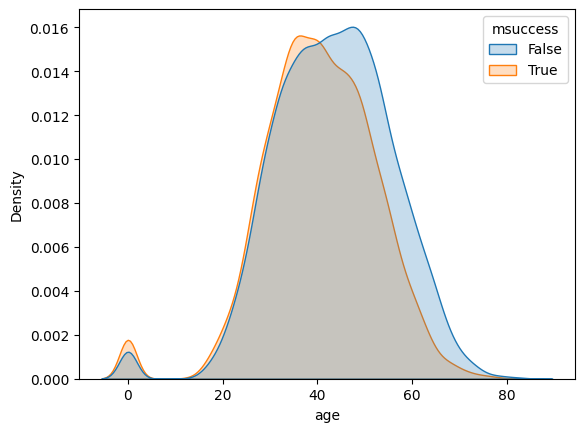

In [1807]:
sns.kdeplot(data=df, x='age', hue='msuccess', fill=True)

<Axes: xlabel='totmembers', ylabel='Density'>

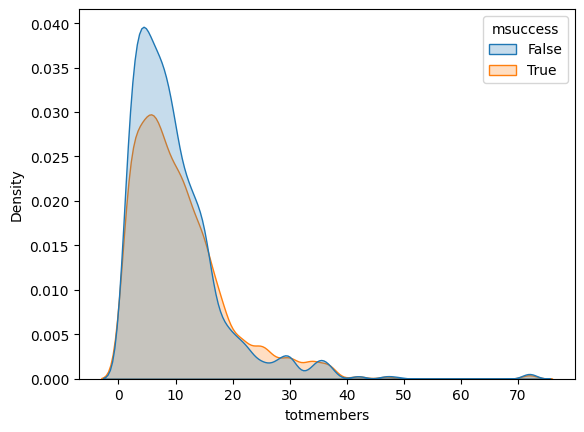

In [1808]:
sns.kdeplot(data=df, x='totmembers', hue='msuccess', fill=True)

<Axes: xlabel='smthired', ylabel='Density'>

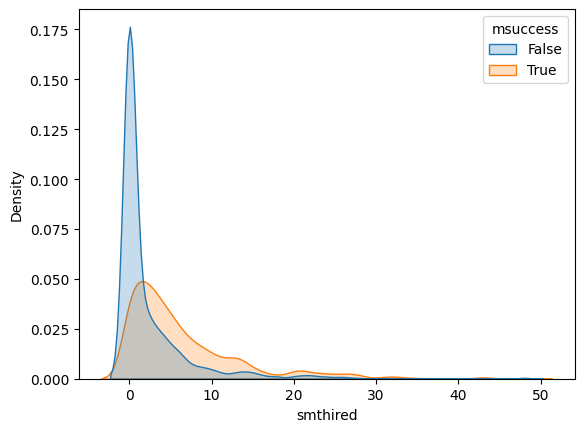

In [1809]:
sns.kdeplot(data=df, x='smthired', hue='msuccess', fill=True)

### Mutual Information

In [1810]:
def compute_success_mutual_info(series: pd.Series) -> float:
  return mutual_info_score(df.msuccess, series)

In [1811]:
mutual_scores = df.drop('msuccess', axis=1).select_dtypes(exclude='number').apply(compute_success_mutual_info)
mutual_scores.sort_values(ascending=False)

comrte     0.015798
himal      0.013203
region     0.009331
stdrte     0.007676
nohired    0.004134
host       0.001222
leader     0.000595
sex        0.000520
deputy     0.000170
msolo      0.000087
dtype: float64

### Correlation

In [1812]:
def compute_success_correlation(series):
  return series.corrwith(df.msuccess)

In [1813]:
corrs = df.select_dtypes('number').corrwith(df.msuccess)
corrs.sort_values(ascending=False)

smtmembers           0.411737
smthired             0.313133
camps                0.202520
tothired             0.143454
heightm              0.119298
member_experience    0.058596
totmembers           0.056971
agency_experience   -0.020792
rope                -0.058400
season              -0.075555
age                 -0.122407
dtype: float64

Variables relative to team size have the highest correlation with the probability of success.

## Feature Preparation
### Validation Framework

In [1814]:
def split_dataset(df: pd.DataFrame, target_var: str):
  df = df.copy()

  # create train/val/test splits
  df_train_full, df_test = train_test_split(df.drop(target_var, axis=1), test_size=.2, random_state=42)
  df_train, df_val = train_test_split(df_train_full, test_size=.25, random_state=42)

  # extract the target variable for each split
  y_train = df.loc[df_train.index, target_var].reset_index(drop=True)
  y_val = df.loc[df_val.index, target_var].reset_index(drop=True)
  y_test = df.loc[df_test.index, target_var].reset_index(drop=True)

  # drop the target variable from each split
  df_train.reset_index(drop=True, inplace=True)
  df_val.reset_index(drop=True, inplace=True)
  df_test.reset_index(drop=True, inplace=True)

  return (df_train, y_train), (df_val, y_val), (df_test, y_test)

In [1815]:
(df_train, y_train), (df_val, y_val), (df_test, y_test) = split_dataset(df, 'msuccess')

In [1816]:
print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(13815, 21)
(4606, 21)
(4606, 21)


### Variable Encoding

In [1817]:
def encode_categorical_vars(df: pd.DataFrame, dv: DictVectorizer = None) -> pd.DataFrame:
  df_dicts = df.to_dict(orient='records')

  if not dv:
    dv = DictVectorizer(sparse=False)
    dv.fit(df_dicts)
  
  df_encoded = pd.DataFrame(
    data=dv.transform(df_dicts),
    columns=dv.get_feature_names_out()
  )

  return df_encoded, dv

In [1818]:
X_train, dv = encode_categorical_vars(df_train)
X_val, _ = encode_categorical_vars(df_val, dv)
X_test, _ = encode_categorical_vars(df_test, dv)

In [1819]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(13815, 50)
(4606, 50)
(4606, 50)


## Model Training
### Logistic Regressor
#### Base Model

In [1820]:
model = LogisticRegression(solver='liblinear', random_state=42)
model.fit(X=X_train, y=y_train)

LogisticRegression(random_state=42, solver='liblinear')

In [1821]:
y_pred = model.predict_proba(X_val)[:,1]

In [1822]:
thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
  score = accuracy_score(y_val, y_pred >= t)
  scores.append(score)

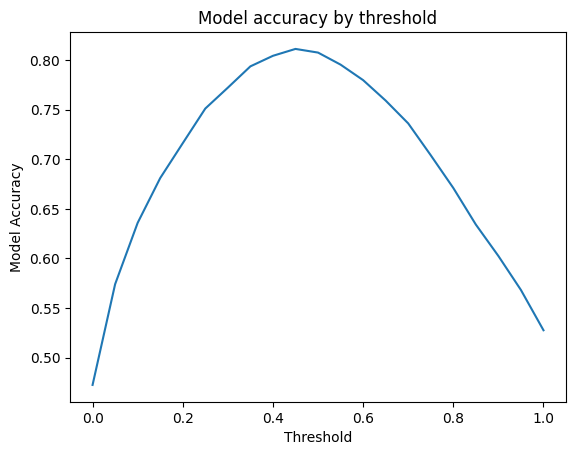

In [1823]:
plt.plot(thresholds, scores)
plt.title('Model accuracy by threshold')
plt.xlabel('Threshold')
plt.ylabel('Model Accuracy')
plt.show()

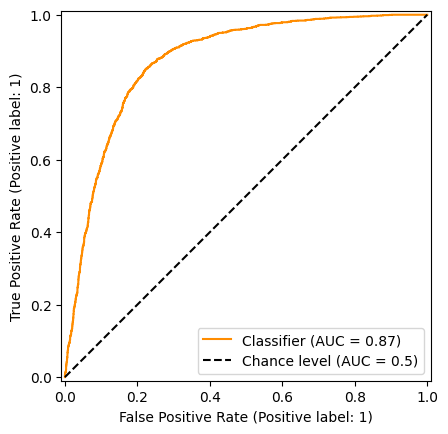

In [1824]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
display = RocCurveDisplay.from_predictions(
  y_val,
  y_pred,
  color="darkorange",
  plot_chance_level=True,)

In [1825]:
confusion_matrix(y_val, y_pred >= .5)

array([[1970,  460],
       [ 426, 1750]])

In [1826]:
roc_auc_score(y_val, y_pred >= .5)

0.8074637648269184

In [1827]:
accuracy_score(y_val, y_pred >= .5)

0.8076422058184977

#### Feature Selection

In [1828]:
pred_val = model.predict(X_val)
full_model_val_accuracy = accuracy_score(y_val, y_pred=pred_val)
full_model_val_accuracy

0.8076422058184977

In [1829]:
features_list = df.drop('msuccess', axis=1).columns.to_list()

In [1830]:
best_feature_set = features_list
largest_change = 0

for col in features_list:
  # manually select features
  features_subset = features_list.copy()
  features_subset.append('msuccess')
  features_subset.remove(col)
  
  # split dataset
  df_subset = df[features_subset]
  (df_train, y_train), (df_val, y_val), (df_test, y_test) = split_dataset(df_subset, 'msuccess')

  # encode data
  X_train, encoder = encode_categorical_vars(df_train)
  X_val, _ = encode_categorical_vars(df_val, encoder)
  X_test, _ = encode_categorical_vars(df_test, encoder)

  # train model
  model = LogisticRegression(solver='liblinear', random_state=42)
  model.fit(X_train, y_train)

  preds_val = model.predict(X_val)
  val_accuracy = accuracy_score(y_val, preds_val)
  accuracy_change = round(100 * (val_accuracy - full_model_val_accuracy), 2)

  if accuracy_change > largest_change:
    largest_change = accuracy_change
    best_feature_set = features_subset
  
  print(f'Dropped feature: {col} | Accuracy change: {accuracy_change}%')

Dropped feature: sex | Accuracy change: 0.11%
Dropped feature: age | Accuracy change: -0.09%
Dropped feature: leader | Accuracy change: -0.26%
Dropped feature: deputy | Accuracy change: 0.09%
Dropped feature: msolo | Accuracy change: 0.3%
Dropped feature: member_experience | Accuracy change: 0.0%
Dropped feature: season | Accuracy change: -0.2%
Dropped feature: host | Accuracy change: 0.02%
Dropped feature: camps | Accuracy change: 0.41%
Dropped feature: rope | Accuracy change: 0.07%
Dropped feature: totmembers | Accuracy change: -5.23%
Dropped feature: smtmembers | Accuracy change: -8.25%
Dropped feature: tothired | Accuracy change: 0.52%
Dropped feature: smthired | Accuracy change: 0.09%
Dropped feature: nohired | Accuracy change: 0.35%
Dropped feature: stdrte | Accuracy change: -0.04%
Dropped feature: comrte | Accuracy change: 0.24%
Dropped feature: agency_experience | Accuracy change: -0.39%
Dropped feature: heightm | Accuracy change: -0.17%
Dropped feature: himal | Accuracy change

#### Parameter Tuning

In [1831]:
C_values = [.01, .03, .1, .3,  1, 3, 10, 30, 100]

best_C = 0
best_accuracy = 0

# split dataset
(df_train, y_train), (df_val, y_val), (df_test, y_test) = split_dataset(df[best_feature_set], 'msuccess')

# encode data
X_train, encoder = encode_categorical_vars(df_train)
X_val, _ = encode_categorical_vars(df_val, encoder)
X_test, _ = encode_categorical_vars(df_test, encoder)

# train models
for C_val in C_values:
  model = LogisticRegression(solver='liblinear', C=C_val, random_state=42)
  model.fit(X_train, y_train)

  preds_val = model.predict(X_val)
  val_accuracy = round(accuracy_score(y_val, preds_val), 3)

  if val_accuracy > best_accuracy:
    best_accuracy = val_accuracy
    best_C = C_val
    
  print(f'{C_val}: {val_accuracy}')

0.01: 0.811
0.03: 0.812
0.1: 0.813
0.3: 0.813
1: 0.813
3: 0.813
10: 0.812
30: 0.813
100: 0.813


#### Full Model

In [1832]:
# split dataset
(df_train, y_train), (df_val, y_val), (df_test, y_test) = split_dataset(df[best_feature_set], 'msuccess')
df_train_full = pd.concat([df_train, df_val], ignore_index=True)
y_train_full = pd.concat([y_train, y_val], ignore_index=True)

# encode data
X_train_full, encoder = encode_categorical_vars(df_train_full)
X_test, _ = encode_categorical_vars(df_test, encoder)

In [1833]:
model = LogisticRegression(solver='liblinear', C=best_C, random_state=42)
model.fit(X_train_full, y_train_full)

LogisticRegression(C=0.1, random_state=42, solver='liblinear')

In [1834]:
preds_test = model.predict(X_test)
accuracy_score(y_test, preds_test)

0.8078593139383413

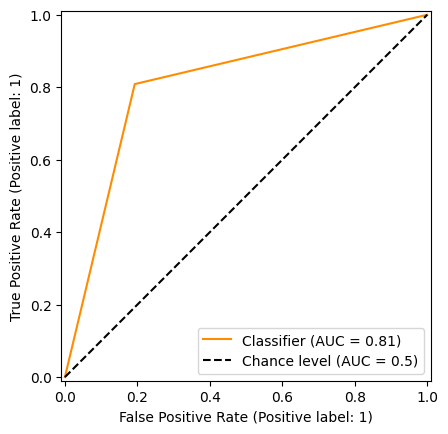

In [1835]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
display = RocCurveDisplay.from_predictions(
  y_test,
  preds_test,
  color="darkorange",
  plot_chance_level=True,)

In [1836]:
lr_model_accuracy = round(accuracy_score(y_test, preds_test), 2)
lr_model_roc_auc = round(roc_auc_score(y_test, preds_test), 2)

In [1837]:
print(lr_model_accuracy)
print(lr_model_roc_auc)

0.81
0.81


In [1838]:
confusion_matrix(y_test, preds_test)

array([[2018,  482],
       [ 403, 1703]])

### Decision Tree
#### Base Model

In [1839]:
(df_train, y_train), (df_val, y_val), (df_test, y_test) = split_dataset(df, 'msuccess')

In [1840]:
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [1841]:
y_pred = model.predict_proba(X_val)[:,1]

In [1842]:
thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
  score = accuracy_score(y_val, y_pred >= t)
  scores.append(score)

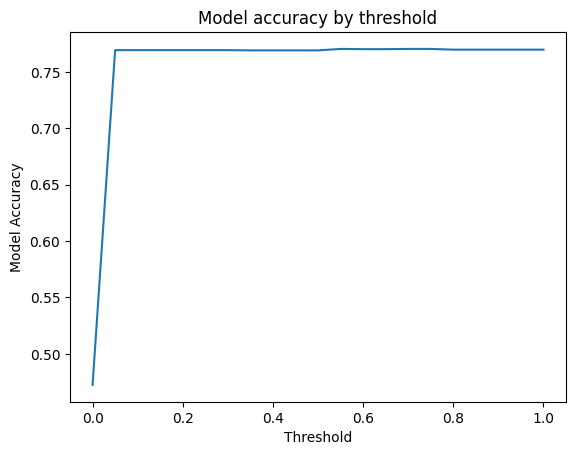

In [1843]:
plt.plot(thresholds, scores)
plt.title('Model accuracy by threshold')
plt.xlabel('Threshold')
plt.ylabel('Model Accuracy')
plt.show()

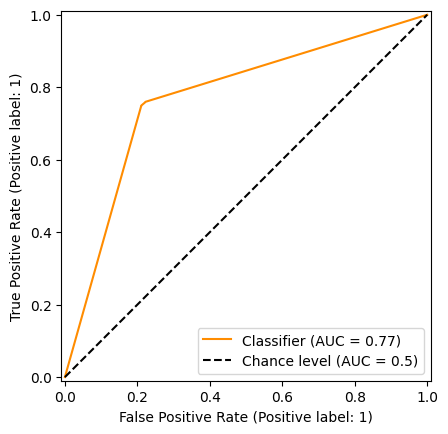

In [1844]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
display = RocCurveDisplay.from_predictions(
  y_val,
  y_pred,
  color="darkorange",
  plot_chance_level=True,)

In [1845]:
confusion_matrix(y_val, y_pred >= .5)

array([[1892,  538],
       [ 526, 1650]])

In [1846]:
roc_auc_score(y_val, y_pred >= .5)

0.7684364409343984

In [1847]:
accuracy_score(y_val, y_pred >= .5)

0.7689969604863222

#### Feature Selection

In [1848]:
pred_val = model.predict(X_val)

In [1849]:
full_model_val_accuracy = accuracy_score(y_val, y_pred=pred_val)
full_model_val_accuracy

0.7702996092053843

In [1850]:
features_list = df.drop('msuccess', axis=1).columns.to_list()

In [1851]:
best_feature_set = features_list
largest_change = 0

for col in features_list:
  # manually select features
  features_subset = features_list.copy()
  features_subset.append('msuccess')
  features_subset.remove(col)
  
  # split dataset
  df_subset = df[features_subset]
  (df_train, y_train), (df_val, y_val), (df_test, y_test) = split_dataset(df_subset, 'msuccess')

  # encode data
  X_train, encoder = encode_categorical_vars(df_train)
  X_val, _ = encode_categorical_vars(df_val, encoder)
  X_test, _ = encode_categorical_vars(df_test, encoder)

  # train model
  model = DecisionTreeClassifier(random_state=42)
  model.fit(X_train, y_train)

  preds_val = model.predict(X_val)
  val_accuracy = accuracy_score(y_val, preds_val)
  accuracy_change = round(100 * (val_accuracy - full_model_val_accuracy), 2)

  if accuracy_change > largest_change:
    largest_change = accuracy_change
    best_feature_set = features_subset
  
  print(f'Dropped feature: {col} | Accuracy change: {accuracy_change}%')

Dropped feature: sex | Accuracy change: -1.0%
Dropped feature: age | Accuracy change: -0.48%
Dropped feature: leader | Accuracy change: 0.17%
Dropped feature: deputy | Accuracy change: -0.37%
Dropped feature: msolo | Accuracy change: -0.63%
Dropped feature: member_experience | Accuracy change: -0.63%
Dropped feature: season | Accuracy change: -0.61%
Dropped feature: host | Accuracy change: -0.67%
Dropped feature: camps | Accuracy change: -0.37%
Dropped feature: rope | Accuracy change: -0.52%
Dropped feature: totmembers | Accuracy change: -2.17%
Dropped feature: smtmembers | Accuracy change: -5.54%
Dropped feature: tothired | Accuracy change: 0.0%
Dropped feature: smthired | Accuracy change: 0.5%
Dropped feature: nohired | Accuracy change: -0.67%
Dropped feature: stdrte | Accuracy change: -0.61%
Dropped feature: comrte | Accuracy change: -0.39%
Dropped feature: agency_experience | Accuracy change: -0.3%
Dropped feature: heightm | Accuracy change: -0.65%
Dropped feature: himal | Accuracy

#### Parameter Tuning
##### Max Depth

In [1852]:
# split dataset
(df_train, y_train), (df_val, y_val), (df_test, y_test) = split_dataset(df[best_feature_set], 'msuccess')

# encode data
X_train, encoder = encode_categorical_vars(df_train)
X_val, _ = encode_categorical_vars(df_val, encoder)
X_test, _ = encode_categorical_vars(df_test, encoder)

In [1853]:
depths = [1, 2, 3, 4, 5, 6, 10, 15, 20, None]

best_depth = 0
best_accuracy = 0

# train models
for depth_val in depths:
  model = DecisionTreeClassifier(max_depth=depth_val, random_state=42)
  model.fit(X_train, y_train)

  preds_val = model.predict(X_val)
  val_accuracy = round(accuracy_score(y_val, preds_val), 3)

  if val_accuracy > best_accuracy:
    best_accuracy = val_accuracy
    best_depth = depth_val
    
  print(f'{depth_val}: {val_accuracy}')

1: 0.762
2: 0.762
3: 0.783
4: 0.785
5: 0.804
6: 0.805
10: 0.816
15: 0.791
20: 0.775
None: 0.775


##### Min Samples Leaf

In [1854]:
min_samples = [1, 2, 5, 10, 15, 20, 100, 200, 500]

best_m = 0
best_accuracy = 0

# train models
for m_val in min_samples:
  model = DecisionTreeClassifier(max_depth=best_depth, min_samples_leaf=m_val, random_state=42)
  model.fit(X_train, y_train)

  preds_val = model.predict(X_val)
  val_accuracy = round(accuracy_score(y_val, preds_val), 3)

  if val_accuracy > best_accuracy:
    best_accuracy = val_accuracy
    best_m = m_val
    
  print(f'{m_val}: {val_accuracy}')

1: 0.816
2: 0.815
5: 0.819
10: 0.816
15: 0.82
20: 0.825
100: 0.818
200: 0.815
500: 0.802


#### Final Model

In [1855]:
# split dataset
(df_train, y_train), (df_val, y_val), (df_test, y_test) = split_dataset(df[best_feature_set], 'msuccess')
df_train_full = pd.concat([df_train, df_val], ignore_index=True)
y_train_full = pd.concat([y_train, y_val], ignore_index=True)

In [1856]:
# encode data
X_train_full, encoder = encode_categorical_vars(df_train_full)
X_test, _ = encode_categorical_vars(df_test, encoder)

In [1857]:
model = DecisionTreeClassifier(max_depth=best_depth, min_samples_leaf=best_m, random_state=42)
model.fit(X_train_full, y_train_full)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=20, random_state=42)

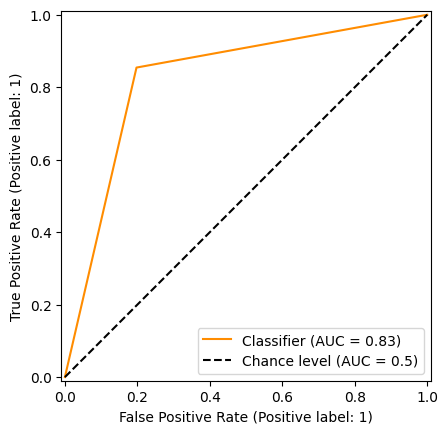

In [1858]:
preds_test = model.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_val, y_pred)
display = RocCurveDisplay.from_predictions(
  y_test,
  preds_test,
  color="darkorange",
  plot_chance_level=True,)

In [1859]:
dt_model_accuracy = round(accuracy_score(y_test, preds_test), 2)
dt_model_roc_auc = round(roc_auc_score(y_test, preds_test), 2)
print(dt_model_accuracy)
print(dt_model_roc_auc)

0.83
0.83


In [1860]:
confusion_matrix(y_test, preds_test)

array([[2006,  494],
       [ 307, 1799]])

### Random Forest
#### Base Model

In [1861]:
(df_train, y_train), (df_val, y_val), (df_test, y_test) = split_dataset(df, 'msuccess')

In [1862]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [1863]:
y_pred = model.predict_proba(X_val)[:,1]

In [1864]:
thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
  score = accuracy_score(y_val, y_pred >= t)
  scores.append(score)

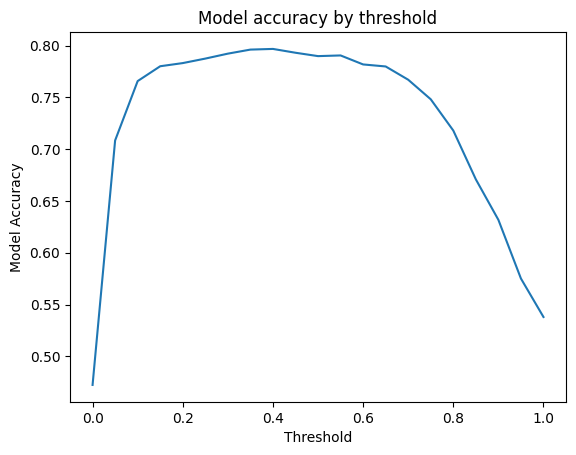

In [1865]:
plt.plot(thresholds, scores)
plt.title('Model accuracy by threshold')
plt.xlabel('Threshold')
plt.ylabel('Model Accuracy')
plt.show()

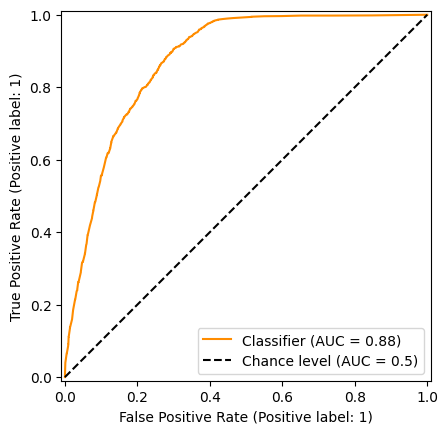

In [1866]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
display = RocCurveDisplay.from_predictions(
  y_val,
  y_pred,
  color="darkorange",
  plot_chance_level=True,)

In [1867]:
confusion_matrix(y_val, y_pred >= .5)

array([[1855,  575],
       [ 393, 1783]])

In [1868]:
roc_auc_score(y_val, y_pred >= .5)

0.7913839339748245

In [1869]:
accuracy_score(y_val, y_pred >= .5)

0.7898393399913157

#### Feature Selection

In [1870]:
pred_val = model.predict(X_val)

In [1871]:
full_model_val_accuracy = accuracy_score(y_val, y_pred=pred_val)
full_model_val_accuracy

0.7885366912722536

In [1872]:
features_list = df.drop('msuccess', axis=1).columns.to_list()

In [1873]:
best_feature_set = features_list
largest_change = 0

for col in features_list:
  # manually select features
  features_subset = features_list.copy()
  features_subset.append('msuccess')
  features_subset.remove(col)
  
  # split dataset
  df_subset = df[features_subset]
  (df_train, y_train), (df_val, y_val), (df_test, y_test) = split_dataset(df_subset, 'msuccess')

  # encode data
  X_train, encoder = encode_categorical_vars(df_train)
  X_val, _ = encode_categorical_vars(df_val, encoder)
  X_test, _ = encode_categorical_vars(df_test, encoder)

  # train model
  model = RandomForestClassifier(random_state=42)
  model.fit(X_train, y_train)

  preds_val = model.predict(X_val)
  val_accuracy = accuracy_score(y_val, preds_val)
  accuracy_change = round(100 * (val_accuracy - full_model_val_accuracy), 2)

  if accuracy_change > largest_change:
    largest_change = accuracy_change
    best_feature_set = features_subset
  
  print(f'Dropped feature: {col} | Accuracy change: {accuracy_change}%')

Dropped feature: sex | Accuracy change: -0.67%
Dropped feature: age | Accuracy change: -1.06%
Dropped feature: leader | Accuracy change: -0.59%
Dropped feature: deputy | Accuracy change: -0.2%
Dropped feature: msolo | Accuracy change: -0.04%
Dropped feature: member_experience | Accuracy change: -0.78%
Dropped feature: season | Accuracy change: 0.37%
Dropped feature: host | Accuracy change: 0.11%
Dropped feature: camps | Accuracy change: 0.0%
Dropped feature: rope | Accuracy change: 0.17%
Dropped feature: totmembers | Accuracy change: -0.46%
Dropped feature: smtmembers | Accuracy change: -3.0%
Dropped feature: tothired | Accuracy change: 0.26%
Dropped feature: smthired | Accuracy change: 0.0%
Dropped feature: nohired | Accuracy change: 0.04%
Dropped feature: stdrte | Accuracy change: 0.0%
Dropped feature: comrte | Accuracy change: 0.04%
Dropped feature: agency_experience | Accuracy change: 0.22%
Dropped feature: heightm | Accuracy change: -0.15%
Dropped feature: himal | Accuracy change:

#### Parameter Tuning
##### Estimators

In [1874]:
# split dataset
(df_train, y_train), (df_val, y_val), (df_test, y_test) = split_dataset(df[best_feature_set], 'msuccess')

# encode data
X_train, encoder = encode_categorical_vars(df_train)
X_val, _ = encode_categorical_vars(df_val, encoder)
X_test, _ = encode_categorical_vars(df_test, encoder)

In [1875]:
estimators = range(10, 201, 10)

best_n = 0
best_accuracy = 0

# train models
for n in estimators:
  model = RandomForestClassifier(n_estimators=n, random_state=42)
  model.fit(X_train, y_train)

  preds_val = model.predict(X_val)
  val_accuracy = round(accuracy_score(y_val, preds_val), 3)

  if val_accuracy > best_accuracy:
    best_accuracy = val_accuracy
    best_n = n
    
  print(f'{n}: {val_accuracy}')

10: 0.775
20: 0.783
30: 0.785
40: 0.79
50: 0.787
60: 0.789
70: 0.791
80: 0.793
90: 0.793
100: 0.792
110: 0.792
120: 0.792
130: 0.792
140: 0.791
150: 0.791
160: 0.791
170: 0.791
180: 0.791
190: 0.79
200: 0.789


##### Max Depth

In [1876]:
depths = [1, 2, 3, 4, 5, 6, 10, 15, 20, None]

best_depth = 0
best_accuracy = 0

# train models
for depth_val in depths:
  model = RandomForestClassifier(n_estimators=best_n, max_depth=depth_val, random_state=42)
  model.fit(X_train, y_train)

  preds_val = model.predict(X_val)
  val_accuracy = round(accuracy_score(y_val, preds_val), 3)

  if val_accuracy > best_accuracy:
    best_accuracy = val_accuracy
    best_depth = depth_val
    
  print(f'{depth_val}: {val_accuracy}')

1: 0.714
2: 0.722
3: 0.73
4: 0.761
5: 0.779
6: 0.785
10: 0.807
15: 0.81
20: 0.8
None: 0.793


##### Min Samples Leaf

In [1877]:
min_samples = [1, 2, 5, 10, 15, 20, 100, 200, 500]

best_m = 0
best_accuracy = 0

# train models
for m_val in min_samples:
  model = RandomForestClassifier(n_estimators=best_n, max_depth=best_depth, min_samples_leaf=m_val, random_state=42)
  model.fit(X_train, y_train)

  preds_val = model.predict(X_val)
  val_accuracy = round(accuracy_score(y_val, preds_val), 3)

  if val_accuracy > best_accuracy:
    best_accuracy = val_accuracy
    best_m = m_val
    
  print(f'{m_val}: {val_accuracy}')

1: 0.81
2: 0.813
5: 0.815
10: 0.81
15: 0.81
20: 0.811
100: 0.795
200: 0.778
500: 0.736


#### Final Model

In [1878]:
# split dataset
(df_train, y_train), (df_val, y_val), (df_test, y_test) = split_dataset(df[best_feature_set], 'msuccess')
df_train_full = pd.concat([df_train, df_val], ignore_index=True)
y_train_full = pd.concat([y_train, y_val], ignore_index=True)

In [1879]:
# encode data
X_train_full, encoder = encode_categorical_vars(df_train_full)
X_test, _ = encode_categorical_vars(df_test, encoder)

In [1880]:
model = RandomForestClassifier(n_estimators=best_n, max_depth=best_depth, min_samples_leaf=best_m, random_state=42)
model.fit(X_train_full, y_train_full)

RandomForestClassifier(max_depth=15, min_samples_leaf=5, n_estimators=80,
                       random_state=42)

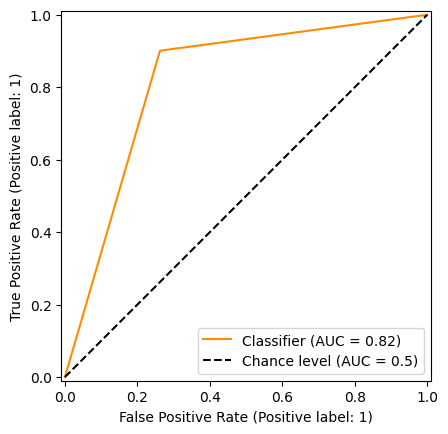

In [1881]:
preds_test = model.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_val, y_pred)
display = RocCurveDisplay.from_predictions(
  y_test,
  preds_test,
  color="darkorange",
  plot_chance_level=True,)

In [1882]:
dt_model_accuracy = round(accuracy_score(y_test, preds_test), 2)
dt_model_roc_auc = round(roc_auc_score(y_test, preds_test), 2)
print(dt_model_accuracy)
print(dt_model_roc_auc)

0.81
0.82


In [1883]:
confusion_matrix(y_test, preds_test)

array([[1844,  656],
       [ 209, 1897]])